# Image generation with Flux.1 and OpenVINO

Flux is a AI image generation model developed by [Black Forest Labs](https://blackforestlabs.ai/our-team/). It represents a significant advancement in AI-generated art, utilizing a hybrid architecture of [multimodal](https://arxiv.org/abs/2403.03206) and [parallel](https://arxiv.org/abs/2302.05442) [diffusion transformer](https://arxiv.org/abs/2212.09748) blocks and scaled to 12B parameter. The model offers state-of-the-art performance image generation with top of the line prompt following, visual quality, image detail and output diversity.More details about model can be found in [blog post](https://blackforestlabs.ai/announcing-black-forest-labs/) and [original repo](https://github.com/black-forest-labs/flux)

<img src="https://raw.githubusercontent.com/black-forest-labs/flux/main/assets/grid.jpg" width="1024" height="800"> 

In this tutorial we consider how to convert and optimized Flux.1 model using OpenVINO.

>**Note**: Some demonstrated models can require at least 32GB RAM for conversion and running.

#### Table of contents:

- [Prerequisites](#Prerequisites)
- [Select model](#Select-model)
- [Convert model with OpenVINO](#Convert-model-with-OpenVINO)
  - [Convert model using Optimum Intel](#Convert-model-using-Optimum-Intel)
  - [Compress model weights](#Compress-model-weights)
- [Run OpenVINO model inference](#Run-OpenVINO-model-inference)
- [Interactive demo](#Interactive-demo)



<img referrerpolicy="no-referrer-when-downgrade" src="https://static.scarf.sh/a.png?x-pxid=5b5a4db0-7875-4bfb-bdbd-01698b5b1a77&file=notebooks/flux.1-image-generation/flux.1-image-generation.ipynb" />

### Installation Instructions

This is a self-contained example that relies solely on its own code.

We recommend  running the notebook in a virtual environment. You only need a Jupyter server to start.
For details, please refer to [Installation Guide](https://github.com/openvinotoolkit/openvino_notebooks/blob/latest/README.md#-installation-guide).

## Prerequisites
[back to top ⬆️](#Table-of-contents:)

In [ ]:
%pip install -q "gradio>=4.19" "torch>=2.1"  "transformers" "nncf>=2.12.0" "diffusers>=0.31.0" "opencv-python" "pillow" "peft>=0.7.0" --extra-index-url https://download.pytorch.org/whl/cpu
%pip install -q "sentencepiece" "protobuf"
%pip install -q "git+https://github.com/huggingface/optimum-intel.git"
%pip install -qU "openvino>=2024.4.0"

In [1]:
import requests
from pathlib import Path

if not Path("cmd_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/cmd_helper.py")
    open("cmd_helper.py", "w").write(r.text)

if not Path("gradio_helper.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/notebooks/flux.1-image-generation/gradio_helper.py")
    open("gradio_helper.py", "w").write(r.text)

if not Path("notebook_utils.py").exists():
    r = requests.get(url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py")
    open("notebook_utils.py", "w").write(r.text)

# Read more about telemetry collection at https://github.com/openvinotoolkit/openvino_notebooks?tab=readme-ov-file#-telemetry
from notebook_utils import collect_telemetry

collect_telemetry("flux.1-image-generation.ipynb")

## Select model
[back to top ⬆️](#Table-of-contents:)

To strike a balance between accessibility and model capabilities, FLUX.1 comes in three variants: FLUX.1-pro, FLUX.1-dev and FLUX.1-schnell: 
* **FLUX.1-pro**: The best of FLUX.1, offering state-of-the-art performance image generation with top of the line prompt following, visual quality, image detail and output diversity, but not available for public usage.
* **FLUX.1-dev**: FLUX.1-dev is an open-weight, guidance-distilled models. Directly distilled from FLUX.1-pro, FLUX.1-dev obtains similar quality and prompt adherence capabilities, while being more efficient than a standard model of the same size. FLUX.1-dev weights are available on [HuggingFace](https://huggingface.co/black-forest-labs/FLUX.1-dev).
* **FLUX.1-schnell**: the fastest model from Flux family is tailored for local development and personal use. FLUX.1-schnell is openly available under an Apache2.0 license. Similar, FLUX.1-dev, weights are available on [HuggingFace](https://huggingface.co/black-forest-labs/FLUX.1-schnell).

![family.png](https://github.com/user-attachments/assets/c7f9df6b-cff3-4d33-98d7-1bb400b2861c)

Be default, we will use FLUX.1-schnell model, but you can switch to FLUX.1-dev version using widget bellow.

In [2]:
import ipywidgets as widgets

model_ids = ["black-forest-labs/FLUX.1-schnell", "black-forest-labs/FLUX.1-dev"]

model_selector = widgets.Dropdown(
    options=model_ids,
    default=model_ids[0],
    description="Model:",
)


model_selector

Dropdown(description='Model:', options=('black-forest-labs/FLUX.1-schnell', 'black-forest-labs/FLUX.1-dev'), v…

>**Note**: run Flux.1-dev model with notebook, you will need to accept license agreement. 
>You must be a registered user in 🤗 Hugging Face Hub. Please visit [HuggingFace model card](https://huggingface.co/black-forest-labs/FLUX.1-dev), carefully read terms of usage and click accept button.  You will need to use an access token for the code below to run. For more information on access tokens, refer to [this section of the documentation](https://huggingface.co/docs/hub/security-tokens).
>You can login on Hugging Face Hub in notebook environment, using following code:

In [3]:
# uncomment these lines to login to huggingfacehub to get access to pretrained model

# from huggingface_hub import notebook_login, whoami

# try:
#     whoami()
#     print('Authorization token already provided')
# except OSError:
#     notebook_login()

## Convert model with OpenVINO
[back to top ⬆️](#Table-of-contents:)

Starting from 2023.0 release, OpenVINO supports PyTorch models directly via Model Conversion API. `ov.convert_model` function accepts instance of PyTorch model and example inputs for tracing and returns object of `ov.Model` class, ready to use or save on disk using `ov.save_model` function. 


The pipeline consists of four important parts:

* Clip and T5 Text Encoders to create condition to generate an image from a text prompt.
* Transformer for step-by-step denoising latent image representation.
* Autoencoder (VAE) for decoding latent space to image.
  
### Convert model using Optimum Intel
[back to top ⬆️](#Table-of-contents:)

For convenience, we will use OpenVINO integration with HuggingFace Optimum. 🤗 [Optimum Intel](https://huggingface.co/docs/optimum/intel/index) is the interface between the 🤗 Transformers and Diffusers libraries and the different tools and libraries provided by Intel to accelerate end-to-end pipelines on Intel architectures.

Among other use cases, Optimum Intel provides a simple interface to optimize your Transformers and Diffusers models, convert them to the OpenVINO Intermediate Representation (IR) format and run inference using OpenVINO Runtime. `optimum-cli` provides command line interface for model conversion and optimization. 

General command format:

```bash
optimum-cli export openvino --model <model_id_or_path> --task <task> <output_dir>
```

where task is task to export the model for, if not specified, the task will be auto-inferred based on the model. You can find a mapping between tasks and model classes in Optimum TaskManager [documentation](https://huggingface.co/docs/optimum/exporters/task_manager). Additionally, you can specify weights compression using `--weight-format` argument with one of following options: `fp32`, `fp16`, `int8` and `int4`. Fro int8 and int4 [nncf](https://github.com/openvinotoolkit/nncf) will be used for  weight compression. More details about model export provided in [Optimum Intel documentation](https://huggingface.co/docs/optimum/intel/openvino/export#export-your-model).

### Compress model weights
[back to top ⬆️](#Table-of-contents:)

For reducing model memory consumption we will use weights compression. The [Weights Compression](https://docs.openvino.ai/2024/openvino-workflow/model-optimization-guide/weight-compression.html) algorithm is aimed at compressing the weights of the models and can be used to optimize the model footprint and performance of large models where the size of weights is relatively larger than the size of activations, for example, Large Language Models (LLM). Compared to INT8 compression, INT4 compression improves performance even more, but introduces a minor drop in prediction quality. We will use [NNCF](https://github.com/openvinotoolkit/nncf) integration to `optimum-cli` tool for weight compression.


In [4]:
to_compress = widgets.Checkbox(
    value=True,
    description="Weight compression",
    disabled=False,
)

to_compress

Checkbox(value=True, description='Weight compression')

In [5]:
from pathlib import Path

model_id = model_selector.value

model_base_dir = Path(model_id.split("/")[-1])
additional_args = {}

if to_compress.value:
    model_dir = model_base_dir / "INT4"
    additional_args.update({"weight-format": "int4", "group-size": "64", "ratio": "1.0"})
else:
    model_dir = model_base_dir / "FP16"
    additional_args.update({"weight-format": "fp16"})

In [6]:
from cmd_helper import optimum_cli

if not model_dir.exists():
    optimum_cli(model_id, model_dir, additional_args=additional_args)

## Run OpenVINO model inference
[back to top ⬆️](#Table-of-contents:)

`OVDiffusionPipeline` from Optimum Intel provides ready-to-use interface for running Diffusers models using OpenVINO. It supports various models including Stable Diffusion, Stable Diffusion XL, LCM, Stable Diffusion v3 and Flux. Similar to original Diffusers pipeline, for initialization, we should use `from_preptrained` method providing model id from HuggingFace hub or local directory (both original PyTorch and OpenVINO models formats supported, in the first case model class additionally will trigger model conversion).

In [7]:
from notebook_utils import device_widget

device = device_widget(default="CPU", exclude=["NPU"])
device

Dropdown(description='Device:', options=('CPU', 'AUTO'), value='CPU')

In [8]:
import ipywidgets as widgets

model_available = (model_base_dir / "INT4").is_dir()
use_quantized_models = widgets.Checkbox(
    value=model_available,
    description="Use compressed models",
    disabled=not model_available,
)

use_quantized_models

Checkbox(value=True, description='Use compressed models')

In [9]:
from optimum.intel.openvino import OVDiffusionPipeline

model_dir = model_base_dir / "INT4" if use_quantized_models.value else model_base_dir / "FP16"

ov_pipe = OVDiffusionPipeline.from_pretrained(model_dir, device=device.value)

2024-10-28 18:12:30.714636: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-28 18:12:30.727116: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730124750.741387   52454 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730124750.745955   52454 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-28 18:12:30.761443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

  0%|          | 0/4 [00:00<?, ?it/s]

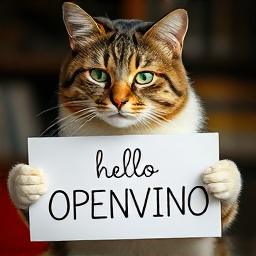

In [10]:
import torch

prompt = "A cat holding a sign that says hello OpenVINO"
image = ov_pipe(
    prompt, guidance_scale=0.0, num_inference_steps=4, max_sequence_length=256, generator=torch.Generator("cpu").manual_seed(0), height=256, width=256
).images[0]

image

## Interactive demo
[back to top ⬆️](#Table-of-contents:)

In [ ]:
from gradio_helper import make_demo

demo = make_demo(ov_pipe)

# if you are launching remotely, specify server_name and server_port
#  demo.launch(server_name='your server name', server_port='server port in int')
# if you have any issue to launch on your platform, you can pass share=True to launch method:
# demo.launch(share=True)
# it creates a publicly shareable link for the interface. Read more in the docs: https://gradio.app/docs/
try:
    demo.launch(debug=True)
except Exception:
    demo.launch(debug=True, share=True)